# BeachBoys BikeShare

Deze workshop is een ML gefocuste versie van de BeachBoys BikeSharing case. In deze case onderzoeken we één van hun bedrijfsproblemen en zorgen we voor een slimme oplossing aan de hand van data.<br>
BeachBoys BikeShare is een fiets sharing bedrijf in de Bay Area. Ze hebben verschillende stations met fietsenstallingen waar klanten op elk moment een fiets kunnen huren. Ze kunnen vervolgens de fiets terugbrengen naar eender welk van hun stations.<br>
Het probleem waar we op gaan inzoomen vandaag is het optimaal gebruik van hun fietsen. Elk station heeft een bepaalde hoeveelheid stallingen, wanneer er geen fietsen beschikbaar zijn, verliezen we klanten aangezien ze geen trip kunnen maken. Wanneer het station vol is verliezen we klantentevredenheid, aangezien de klanten niet langer kunnen afstappen waar ze willen.<br>
Momenteel is er een wagen die voltijds rondrijdt en extra fietsen ophaalt/levert waar nodig, deze rijdt echter louter op goed gevoel. Het zou handig zijn moesten we deze kunnen sturen naar de locaties waar de hulp nodig is. De auto heeft natuurlijk tijd nodig om te navigeren tussen de verschillende stations, we zouden dus een periode op voorhand al moeten kunnen voorspellen waar deze drukke stations zich bevinden. Een ideale taak voor machine learning!<br><br>


Korte vraag: Wat voor machine learning model hebben we hiervoor nodig? <br> <br>

## Inhoud
- Importeer Libraries
- Data Analyse
   - Station Data
   - Trip Data
   - Weer Data
- Data Transformatie
- Model Trainen
   - Baseline wiskundig model
   - Lineaire regressie
   - Ridge regressie
   - Decision Tree (Beslissingboom)
   - Random Forest
   - Gradient Boosting
   - Multilayer Perceptron
- Visualiseren


Tijden het analyseren van de data gaan we jullie zelf laten experimenteren met de verschillende beschikbare data en het plotten ervan om inzichten te creëren.<br>
Het transformeren van de data is verdere oefening op het gebruik van pandas om data voor te bereiden voor machine learning modellen.<br>
Vervolgens gaan we enkele modellen trainen en evalueren. Hier kunnen we experimenteren met de invloed van verschillende parameters, alsook met het effect van de features.


## Importeer Libraries

In [142]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [143]:
import pandas as pd
import matplotlib.pyplot as plt 
import os
import numpy as np
import shap


# Download en importeer data bestanden

We beginnen met eerst de nodige data in te laden.

In [144]:
# Dit commando opent een popup waar je je moet inloggen op je azure account
!az login

A web browser has been opened at https://login.microsoftonline.com/organizations/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "5d4df24d-6769-4586-9455-dd6db3f30f0e",
    "id": "4a429ac3-22e4-4b7f-a63f-6865c1b7edbe",
    "isDefault": true,
    "managedByTenants": [
      {
        "tenantId": "2f4a9838-26b7-47ee-be60-ccc1fdec5953"
      }
    ],
    "name": "Rootsacademy-Certifications",
    "state": "Enabled",
    "tenantId": "5d4df24d-6769-4586-9455-dd6db3f30f0e",
    "user": {
      "name": "bram.decoster@dataroots.io",
      "type": "user"
    }
  },
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "5d4df24d-6769-4586-9455-dd6db3f30f0e",
    "id": "bc921e01-cc39-4564-9417-037822015aab",
    "isDefault": false,
    "managedByTenants": [
      {
        "tenantId": "2f4a9838-26

In [145]:
# Nu we zijn ingelogt kunnen we verbinden met de storage account en vervolgens de data uit de correcte container halen
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient

try:
    default_credential = DefaultAzureCredential() # regelt de authenticatie

    connection_string = "https://mowworkshopprep.blob.core.windows.net"
    blob_service_client = BlobServiceClient(connection_string,default_credential) #verbinden met de storage account
    container_name = "workshopdata"
    container_client = blob_service_client.get_container_client(container_name) #verbinden met de container

    local_path = "../data"

    blob_list = container_client.list_blobs() #lees alle bestanden in de container
    for blob in blob_list: # Ga over alle bestanden (blobs) en schrijf ze weg
        blob_client = container_client.get_blob_client(blob.name)    
        local_file_path = f"{local_path}/{blob.name}"
        with open(local_file_path, "wb") as local_file:
            local_file.write(blob_client.download_blob().readall())
    
    # Controleer of alle bestanden gedownload zijn
    required_files = ["station_data.csv", "trip_data.csv", "weather_data.csv", "previousValues.csv"]
    for file_name in required_files:
        file_path = os.path.join(local_path, file_name)
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_name} not found in the local folder.")
    print("All required files found in the local folder.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

All required files found in the local folder.


In [146]:
os.listdir("../data")

['.DS_Store',
 'station_data.csv',
 'weather_data.csv',
 'trip_data.csv',
 'previousValues.csv']

# Analyseer de Tabellen

De eerste stap is kijken welke data beschikbaar is, en of hier enkele opvallende trends in te vinden zijn. <br>
Het eerste bestand is 'station_data.csv', elke rij hier vertelt meer over een bepaald station: de locatie, het aantal plaatsen voor fietsen,... <br>
Het tweede bestand bevat een rij voor elke geregistreerde trip, en geeft aan waar en wanneer deze gestart/ beëindigt zijn. Dit is ook de grootste tabel aangezien het informatie bevat voor elke gemaakte trip.<br>
De laatste tabel is informatie over het weer in en rond San Francisco. 

## Station data

In [147]:
station_data = pd.read_csv("../data/station_data.csv")
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


Elk station bevat verschillende gegevens:
- id: een unieke getal voor elk station
- Name: Naam van het station
- Lat: breedtegraad
- Long: lengtegraad
- Dock count: aantal plaatsen voor fietsen in het station
- City: De stad waar het station zich bevind

In [148]:
column_types = station_data.dtypes
print(column_types)

Id              int64
Name           object
Lat           float64
Long          float64
Dock Count      int64
City           object
dtype: object


Het type 'object' betekent string in dit geval. Alle kolommen staan reeds in de juiste vorm.

### Aantal Stations per stad

Text(0, 0.5, 'Aantal Stations')

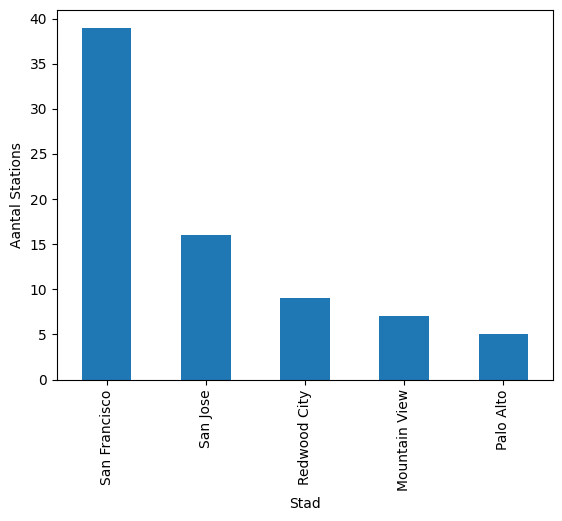

In [149]:
station_data['City'].value_counts().plot(kind="bar")
plt.xlabel("Stad")
plt.ylabel("Aantal Stations")

### Totaal aantal fiestplaatsen per stad

Text(0, 0.5, 'Totaal aantal fietsplaatsen')

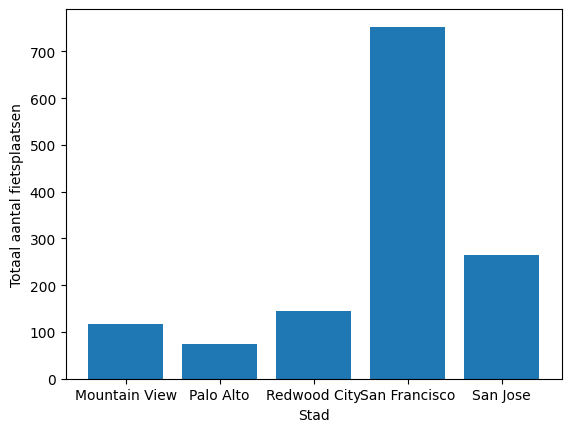

In [150]:
DocksPerCity = station_data.groupby(['City'])['Dock Count'].sum().reset_index()
plt.bar(DocksPerCity['City'],DocksPerCity['Dock Count'])
plt.xlabel("Stad")
plt.ylabel("Totaal aantal fietsplaatsen")

Nu is het aan Jullie, denk aan statestieken die we nog kunnen gebruiken. Gebruik de datasets naar keuze

## Trip data

In [151]:
trip_data = pd.read_csv("../data/trip_data.csv")
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,891070,14/08/2015 23:49,82,14/08/2015 23:55,42,Subscriber
1,891069,14/08/2015 23:49,82,14/08/2015 23:58,87,Subscriber
2,891068,14/08/2015 23:49,60,14/08/2015 23:54,74,Subscriber
3,891067,14/08/2015 23:48,59,14/08/2015 23:51,59,Subscriber
4,891066,14/08/2015 23:38,28,14/08/2015 23:53,27,Subscriber


Elke trip die een persoon maakt bevat de volgende gegevens:
- Trip ID: een uniek nummer voor elke trip
- Start Date: start tijd en datum van de trip
- Start Station: Waar is de trip begonnen
- End Date: eind tijd en datum van de trip
- End Station: Waar is de trip beëindigd
- Subscriber Type: Wat soort abonnement heeft de gebruiker

In [152]:
column_types = trip_data.dtypes
print(column_types)

Trip ID             int64
Start Date         object
Start Station       int64
End Date           object
End Station         int64
Subscriber Type    object
dtype: object


Hier zien we dat de start en eind tijd in string formaat staan. Hierdoor kunnen we niet redeneren over tijd, wat een belangrijk aspect is voor het voorspellen van het aantal fietsen. We moeten deze dus eerst transformeren.

In [153]:
trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'], format='%d/%m/%Y %H:%M')
trip_data['End Date'] = pd.to_datetime(trip_data['End Date'], format='%d/%m/%Y %H:%M')
print(trip_data.dtypes)

Trip ID                     int64
Start Date         datetime64[ns]
Start Station               int64
End Date           datetime64[ns]
End Station                 int64
Subscriber Type            object
dtype: object


In [154]:
trip_data["tripDuration"] = (trip_data['End Date']-trip_data['Start Date']).dt.total_seconds()/60
trip_data

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0
...,...,...,...,...,...,...,...
336925,432951,2014-09-01 04:21:00,39,2014-09-01 04:32:00,65,Subscriber,11.0
336926,432950,2014-09-01 03:16:00,50,2014-09-01 05:08:00,70,Customer,112.0
336927,432949,2014-09-01 00:05:00,66,2014-09-01 00:14:00,57,Customer,9.0
336928,432948,2014-09-01 00:05:00,66,2014-09-01 00:15:00,57,Customer,10.0


In [155]:
minDate = trip_data['Start Date'].min()
minDate

Timestamp('2014-09-01 00:05:00')

In [156]:
maxDate = trip_data['End Date'].max()
maxDate

Timestamp('2015-08-14 23:58:00')

We zien nu dat we ongeveer 1 jaar aan data hebben van September 2014 tot en met Augustus 2015.

Nu zou het ook interessant zijn om naar trends in de tijd te kunnen kijken. Zijn er spitsuren? Is het drukker tijdens het weekend of in de week? Is er een winterstop? Al deze vragen zijn relevant voor het voorspellen waar veel fietsen nodig zijn. <br>
Momenteel staan de tijdstippen opgeslagen in 1 kolom, onbewust kunnen wij dit in onze gedachten al opsplitsen in jaren, maanden, dagen, uren,...<br>
Maar het machine learning model kan dit niet, ook maakt dit het plotten meer ingewikkeld. Daarom splitsen we nu eerst de tijdstippen op.

In [157]:
# Splits Start Date op
trip_data['StartYear'] = trip_data['Start Date'].dt.year
trip_data['StartMonth'] = trip_data['Start Date'].dt.month
trip_data['StartDay'] = trip_data['Start Date'].dt.day
trip_data['StartWeekday'] = trip_data['Start Date'].dt.weekday  # Maandag is 0 en zondag is 6
trip_data['StartHour'] = trip_data['Start Date'].dt.hour
trip_data['StartMinute'] = trip_data['Start Date'].dt.minute

# Splits End Date op
trip_data['EndYear'] = trip_data['End Date'].dt.year
trip_data['EndMonth'] = trip_data['End Date'].dt.month
trip_data['EndDay'] = trip_data['End Date'].dt.day
trip_data['EndWeekday'] = trip_data['End Date'].dt.weekday  # Maandag is 0 en zondag is 6
trip_data['EndHour'] = trip_data['End Date'].dt.hour
trip_data['EndMinute'] = trip_data['End Date'].dt.minute

In [158]:
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0,2015,8,14,4,23,38,2015,8,14,4,23,53


## Weer data

In [159]:
weather_data = pd.read_csv("../data/weather_data.csv")
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [160]:
column_types = weather_data.dtypes
print(column_types)

Date                          object
Max TemperatureF             float64
Mean TemperatureF            float64
Min TemperatureF             float64
Max Dew PointF               float64
MeanDew PointF               float64
Min DewpointF                float64
Max Humidity                 float64
Mean Humidity                float64
Min Humidity                 float64
Max Sea Level PressureIn     float64
Mean Sea Level PressureIn    float64
Min Sea Level PressureIn     float64
Max VisibilityMiles          float64
Mean VisibilityMiles         float64
Min VisibilityMiles          float64
Max Wind SpeedMPH            float64
Mean Wind SpeedMPH           float64
Max Gust SpeedMPH            float64
PrecipitationIn              float64
CloudCover                   float64
Events                        object
WindDirDegrees               float64
Zip                            int64
dtype: object


In [161]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d/%m/%Y')
weather_data = weather_data[weather_data['Zip'] == 94107]
weather_data['Events'] = weather_data['Events'].fillna('None')


# Data transformatie

***Dit deel bevat enkele lijnen code die nog ingevuld moeten worden, let opde TODO's en vul in waar ... staat.***

Nu dat we een beter begrip hebben van de gegevens, is het tijd om de data klaar te maken voor een machine learning model. <br>
De data moet 2 onderdelen bevatten voor we ons model kunnen trainen. <br> 
1. Eerst moeten we een 'Target' hebben, de waarde die we willen voorspellen. In deze opdracht willen we ervoor zorgen dat op elk moment fietsen beschikbaar zijn voor de klanten. We weten niets over het absolute aantal fietsen op een station, dus deze waarde is moeilijk te voorspellen. Wat we wel weten is hoeveel fietsen aankomen en vertrekken op een bepaald station. Hierdoor kunnen we een netto 'verandering aan fietsen' berekenen en ook voorspellen. Deze verandering per uur bekijken lijkt een goeie target, per minuut is te ambitieus en geeft ook geen tijd voor de volgwagen om nieuwe fietsen te leveren waar nodig, en aangezien de meeste trips korter zijn dan één uur gaat per dag een te groot venster zijn. Plaatsen waar we grote veranderingen voorspellen kunnen we de volgauto naartoe sturen, om extra fietsen af/op te laden.<br><br>
2. Ten tweede hebben we features nodig die het model kan gebruiken om onze target te voorspellen. De exploratie die we juist gedaan hebben kan hiervoor nuttig zijn alsook onze eigen intuitie. We zagen bijvoorbeeld dat er 2 piek uren rond 8 en rond 17, het uur is dus een belangrijke feature om de 'verandering aan fietsen' te voorspellen. Andere gegevens zoals de dag van de week, de maand, welk station, het weer zijn allemaal zaken die invloed kunnen hebben op 'verandering aan fietsen'.

In [162]:
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0,2015,8,14,4,23,38,2015,8,14,4,23,53


Dit is de data waar we mee zijn geëindigd na de voorgaande analyse. We kunnen deze eerst wat opschonen en de 
- start/end date 
- tripDuration 
- duration_bins
- Start/End minuten 
verwijderen (We voorspellen per uur dus de minuten zijn niet meer nodig).

In [163]:
columnsToDrop = ['Start Date','End Date','tripDuration','StartMinute','EndMinute']
trip_data = #TODO verwijder de bovenstaande kolommen, hint: gebruik de drop functie

trip_data

,Trip ID,Start Station,End Station,Subscriber Type,StartYear,StartMonth,StartDay,StartWeekday,StartHour,EndYear,EndMonth,EndDay,EndWeekday,EndHour
0,891070,82,42,Subscriber,2015,8,14,4,23,2015,8,14,4,23
1,891069,82,87,Subscriber,2015,8,14,4,23,2015,8,14,4,23
2,891068,60,74,Subscriber,2015,8,14,4,23,2015,8,14,4,23
3,891067,59,59,Subscriber,2015,8,14,4,23,2015,8,14,4,23
4,891066,28,27,Subscriber,2015,8,14,4,23,2015,8,14,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336925,432951,39,65,Subscriber,2014,9,1,0,4,2014,9,1,0,4
336926,432950,50,70,Customer,2014,9,1,0,3,2014,9,1,0,5
336927,432949,66,57,Customer,2014,9,1,0,0,2014,9,1,0,0
336928,432948,66,57,Customer,2014,9,1,0,0,2014,9,1,0,0


Als alles goed zit, hebben we nu 14 kolommen aan data.

Om de netto 'verandering in fietsen' op een bepaald station te voorspellen hebben we 2 onderdelen nodig, de fietsen die aankomen in dit station (End Station) en degene die vertrekken vanaf dit station (Start Station)

In [164]:
IncomingBikes = trip_data.groupby(['Start Station', 'StartYear','StartMonth','StartDay','StartHour']).size().reset_index(name='incoming')
IncomingBikes.head()

,Start Station,StartYear,StartMonth,StartDay,StartHour,incoming
0,2,2014,9,1,12,1
1,2,2014,9,1,21,4
2,2,2014,9,1,22,1
3,2,2014,9,2,1,1
4,2,2014,9,2,7,3


We weten niet of er op elk uur een fiets vertrekt of aankomt op een bepaald station. Dus we maken eerst een dataset aan die voor elk station alle uren bevat.

In [209]:
date_range = pd.date_range(start=minDate, end=maxDate, freq='H')
date_df = pd.DataFrame(date_range, columns=['datetime'])
date_df['dateIndex'] = range(len(date_df)) # We voegen een tijdsindex toe, deze gaat ons later helpen

stations_df = pd.DataFrame(trip_data['Start Station'].unique(), columns=['Station']) # Extraheer alle verschillende stations
stationTime_df = pd.merge(date_df,stations_df,how='cross')
stationTime_df

,datetime,dateIndex,Station
0,2014-09-01 00:05:00,0,82
1,2014-09-01 00:05:00,0,60
2,2014-09-01 00:05:00,0,59
3,2014-09-01 00:05:00,0,28
4,2014-09-01 00:05:00,0,50
...,...,...,...
634747,2015-08-14 23:05:00,8351,69
634748,2015-08-14 23:05:00,8351,72
634749,2015-08-14 23:05:00,8351,49
634750,2015-08-14 23:05:00,8351,23


In [165]:
#Splits de datum terug op
#TODO: splits stationTime_df per jaar
stationTime_df['year'] =  ...
#TODO: splits stationTime_df per maand
stationTime_df['month'] = ...
#TODO: splits stationTime_df per dag
stationTime_df['day'] = ...
#TODO: splits stationTime_df per weekdag
stationTime_df['weekday'] = ...
#TODO: splits stationTime_df per uur
stationTime_df['hour'] = ...
stationTime_df= stationTime_df.drop('datetime',axis=1)
stationTime_df.head()

,dateIndex,Station,year,month,day,weekday,hour
0,0,82,2014,9,1,0,0
1,0,60,2014,9,1,0,0
2,0,59,2014,9,1,0,0
3,0,28,2014,9,1,0,0
4,0,50,2014,9,1,0,0


In [166]:
IncomingBikes = pd.merge(stationTime_df, IncomingBikes, left_on=['Station', 'year','month','day','hour'],right_on=['Start Station','StartYear','StartMonth','StartDay','StartHour'] , how='left')
IncomingBikes = IncomingBikes.drop(['Start Station','StartYear','StartMonth','StartDay','StartHour'],axis=1)

#TODO: Vul de waarde in waar we lege rijen mee opvullen. Als er geen rij beschikbaar was, hoeveel fietsen kwamen er dan aan
IncomingBikes['incoming'] = IncomingBikes['incoming'].fillna(...).astype(int)
IncomingBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


Nu we de aankomende fietsen hebben, doen we hetzelfde voor de vertrekkende fietsen.

In [167]:
#TODO: Op welke kolommen gaan we groeperen?
OutGoingBikes = trip_data.groupby([...]).size().reset_index(name='outgoing')

#TODO: welke tabellen moeten we nu verbinden?
OutGoingBikes = pd.merge(..., ..., left_on=['Station', 'year','month','day','hour'],right_on=['End Station','EndYear','EndMonth','EndDay','EndHour'] , how='left')
OutGoingBikes = OutGoingBikes.drop(['End Station','EndYear','EndMonth','EndDay','EndHour'],axis=1)

#TODO: Vul de waarde in waar we lege rijen mee opvullen. Als er geen rij beschikbaar was, hoeveel fietsen zijn er dan vertrokken?
OutGoingBikes['outgoing'] = OutGoingBikes['outgoing'].fillna(...).astype(int)
OutGoingBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,outgoing
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


Nu moeten we nog het verschil nemen tussen beide om aan het netto verandering van fietsen te komen.

In [168]:
ChangeInBikes = pd.merge(IncomingBikes,OutGoingBikes,on=['dateIndex','Station','year','month','day','hour','weekday'],how= 'left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming,outgoing
0,0,82,2014,9,1,0,0,0,0
1,0,60,2014,9,1,0,0,0,0
2,0,59,2014,9,1,0,0,0,0
3,0,28,2014,9,1,0,0,0,0
4,0,50,2014,9,1,0,0,0,0


In [169]:
#TODO: bereken de netto verandering aan fietsen
ChangeInBikes['netBikeChange'] = ...
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming,outgoing,netBikeChange
0,0,82,2014,9,1,0,0,0,0,0
1,0,60,2014,9,1,0,0,0,0,0
2,0,59,2014,9,1,0,0,0,0,0
3,0,28,2014,9,1,0,0,0,0,0
4,0,50,2014,9,1,0,0,0,0,0


NetBikeChange is onze target value en dus de waarde die we willen voorspellen, de overige kolommen zijn al enkele features die we kunnen gebruiken om de voorspelling te maken. Natuurlijk de incoming en outgoing waardes zijn onbekend tijdens het voorspellen, dus die verwijderen we nog eerst.

In [170]:
ChangeInBikes= ChangeInBikes.drop(['incoming','outgoing'],axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


Nu kunnen we even nadenken welke andere features nog van pas zouden komen.
- Het aantal fiestenstalling in een station
- de Stad waarin het station zich bevindt
- Is het weekend?
- Weer events (regen,mist,...)
- Temperatuur
- Verandering tijdens de laatste uren

### Is het weekend?

In [171]:
#TODO: gebruik de isin functie om weekend dagen aan te duiden in een feature (cast daarna ook de feature naar een int via '.astype(int)')
ChangeInBikes['IsWeekend'] = ChangeInBikes[...]. ...
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend
0,0,82,2014,9,1,0,0,0,0
1,0,60,2014,9,1,0,0,0,0
2,0,59,2014,9,1,0,0,0,0
3,0,28,2014,9,1,0,0,0,0
4,0,50,2014,9,1,0,0,0,0


### In welke stad is het station? En hoeveel fiets plaatsen zijn er?

In [172]:
ChangeInBikes = pd.merge(ChangeInBikes, station_data, left_on='Station', right_on='Id',how='left')

#TODO: verwijder de onnodige kolommen van de data via de drop functie (Id, Lat, Long en Name)
ChangeInBikes = ...
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City
0,0,82,2014,9,1,0,0,0,0,15,San Francisco
1,0,60,2014,9,1,0,0,0,0,15,San Francisco
2,0,59,2014,9,1,0,0,0,0,23,San Francisco
3,0,28,2014,9,1,0,0,0,0,23,Mountain View
4,0,50,2014,9,1,0,0,0,0,23,San Francisco


We kunnen de stad niet zomaar gebruiken, niet alle modellen kunnen werken met categorie waarden. We zullen deze eerst veranderen via one-hot encoding.

In [173]:
#TODO: verander de namen van de steden in 1 woord door spaties te verandering in een laag streepje.
ChangeInBikes['City'] = ChangeInBikes['City'].str.replace(...,...)

citiesEncoded = pd.get_dummies(ChangeInBikes['City'], prefix='City')
ChangeInBikes = pd.concat([ChangeInBikes, citiesEncoded], axis=1)

ChangeInBikes= ChangeInBikes.drop('City',axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose
0,0,82,2014,9,1,0,0,0,0,15,False,False,False,True,False
1,0,60,2014,9,1,0,0,0,0,15,False,False,False,True,False
2,0,59,2014,9,1,0,0,0,0,23,False,False,False,True,False
3,0,28,2014,9,1,0,0,0,0,23,True,False,False,False,False
4,0,50,2014,9,1,0,0,0,0,23,False,False,False,True,False


### Temperatuur en Weer events?

Voor we de 2 features over het weer kunnen toevoegen moeten we de datums van de weer tabel aanpassen. Beide datums moeten in dezelfde vorm staan zodat we de tabellen kunnen verbinden.

In [174]:
weather_data['year'] = weather_data['Date'].dt.year
weather_data['month'] = weather_data['Date'].dt.month
weather_data['day'] = weather_data['Date'].dt.day

#TODO: Transformeer de gemiddelde temperatuur van farenheit naar celcius
weather_data['Mean TemperatureC'] = (... - 32) * 5/9
#TODO: Rond de nieuwe temperaturen af op 2 cijfers na de komma
weather_data['Mean TemperatureC'] = weather_data['Mean TemperatureC']. ...

weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,year,month,day,Mean TemperatureC
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,20.0,0.0,0.0,None,290.0,94107,2014,9,1,21.11
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,NaN,0.0,5.0,None,290.0,94107,2014,9,2,18.89
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,24.0,0.0,4.0,None,276.0,94107,2014,9,3,20.56
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,25.0,0.0,5.0,None,301.0,94107,2014,9,4,20.00
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,32.0,0.0,4.0,None,309.0,94107,2014,9,5,18.89


In [175]:
weather_data_features = weather_data[['year','month','day','Mean TemperatureC','Events']]
weather_data_features.head()

,year,month,day,Mean TemperatureC,Events
0,2014,9,1,21.11,None
1,2014,9,2,18.89,None
2,2014,9,3,20.56,None
3,2014,9,4,20.00,None
4,2014,9,5,18.89,None


De events moeten ook opgesplitst worden per waarde zoals de steden.

In [176]:
#TODO: One hot encode de weer events (tip: gelijkaardig als bij de steden, en prefix met 'Event')
weatherEncoded = ...
weather_data_features = pd.concat([weather_data_features, weatherEncoded], axis=1)
weather_data_features= weather_data_features.drop('Events',axis=1)
weather_data_features.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,month,day,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm
0,2014,9,1,21.11,False,False,True,False,False
1,2014,9,2,18.89,False,False,True,False,False
2,2014,9,3,20.56,False,False,True,False,False
3,2014,9,4,20.00,False,False,True,False,False
4,2014,9,5,18.89,False,False,True,False,False


In [177]:
#TODO: verbind de ChangeInBikes en weather_data_features tabellen via de pd.merge functie.
ChangeInBikes = ...
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,...,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm
0,0,82,2014,9,1,0,0,0,0,15,...,False,False,True,False,21.11,False,False,True,False,False
1,0,60,2014,9,1,0,0,0,0,15,...,False,False,True,False,21.11,False,False,True,False,False
2,0,59,2014,9,1,0,0,0,0,23,...,False,False,True,False,21.11,False,False,True,False,False
3,0,28,2014,9,1,0,0,0,0,23,...,False,False,False,False,21.11,False,False,True,False,False
4,0,50,2014,9,1,0,0,0,0,23,...,False,False,True,False,21.11,False,False,True,False,False


### Wat gebeurde er tijdens de vorige uren?

Een volgend feature dat kan helpen, is een zeer populaire bij het voorspellen van waarden over tijd (Time series predictions). Namelijk de waarde van het vorige uur (of van de vorige uren). Als we terugdenken aan onze piek uren, herinneren we ons dat drukke periodes niet plots opdaagden, maar geleidelijk op en afbouwt. 

Hier komt de tijdsindex terug van pas

In [178]:
def getNetChangeFromPreviousHour(df,dateIndex,station,n=1):
    if (dateIndex-n) > 0:
        prevNetChange = df.loc[(df['dateIndex'] == dateIndex-n) & (df['Station'] == station), 'netBikeChange'].values[0] #loc zoekte specifieke rijen in de data
    else:
        prevNetChange = 0
    return prevNetChange

Dit zijn zwaardere functies aangezien we over elke rij moeten gaan en vervolgens voor elke rij de vorige waardes opzoeken in de tabel. Daarom is er ook een bestandje toegevoegd dat de nodige waardes al bevat. Door deze te linken aan onze tabel kunnen we wat tijd besparen.

In [179]:
#ChangeInBikes['NetBikeChange-1'] = ChangeInBikes.apply(lambda row: getNetChangeFromPreviousHour(ChangeInBikes,row['dateIndex'], row['Station']), axis=1)
#ChangeInBikes['NetBikeChange-2'] = ChangeInBikes.apply(lambda row: getNetChangeFromPreviousHour(ChangeInBikes,row['dateIndex'], row['Station'],2), axis=1)

De volgende functie laad het bestand in en voegt de waardes toe aan de feature tabel.

In [180]:
previousValues = pd.read_csv("../data/previousValues.csv")
ChangeInBikes = pd.merge(ChangeInBikes, previousValues, on=['dateIndex','Station'],how='left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,0,82,2014,9,1,0,0,0,0,15,...,True,False,21.11,False,False,True,False,False,0,0
1,0,60,2014,9,1,0,0,0,0,15,...,True,False,21.11,False,False,True,False,False,0,0
2,0,59,2014,9,1,0,0,0,0,23,...,True,False,21.11,False,False,True,False,False,0,0
3,0,28,2014,9,1,0,0,0,0,23,...,False,False,21.11,False,False,True,False,False,0,0
4,0,50,2014,9,1,0,0,0,0,23,...,True,False,21.11,False,False,True,False,False,0,0


Hier voegen we de veranderingen tijdens de vorige 2 uren toe, we kunnen nog meer van deze historische waardes toevoegen, maar we moeten telkens het nut hiervan afwegen. Elk feature dat we toevoegen maakt ons model iets zwaarder. Hoeveel fietsen er 5 uur geleden zijn bijgekomen gaat weinig tot geen invloed hebben op hoeveel fietsen we nu gaan zien aankomen.<br><br>
Voor we dit deel afmaken verwijderen we nog even de 'dateIndex', deze was handig voor de vorige waardes toe te voegen maar heeft nu geen nut meer.

In [181]:
ChangeInBikes = ChangeInBikes.drop('dateIndex',axis=1)
ChangeInBikes.head()

,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,82,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
1,60,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
2,59,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0
3,28,2014,9,1,0,0,0,0,23,True,...,False,False,21.11,False,False,True,False,False,0,0
4,50,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0


We eindigen met 22 kolommen

# Model trainen

Het trainen van de modellen bevat geen zelf in te vullen lijnen, maar wel verschillende parameters waarmee geexperimenteerd kan worden. Alsook het aantal features waar we aan kunnen sleutelen. Onderstaande code laat ons toe om een aantal features te kiezen om mee verder te gaan. Indien er genoeg tijd is, raad ik zeker aan om terug naar dit punt te komen en hier mee te experimenteren.

In [182]:
ChangeInBikes.columns

Index(['Station', 'year', 'month', 'day', 'weekday', 'hour', 'netBikeChange',
       'IsWeekend', 'Dock Count', 'City_Mountain_View', 'City_Palo_Alto',
       'City_Redwood_City', 'City_San_Francisco', 'City_San_Jose',
       'Mean TemperatureC', 'Event_Fog', 'Event_Fog-Rain', 'Event_None',
       'Event_Rain', 'Event_Rain-Thunderstorm', 'NetBikeChange-1',
       'NetBikeChange-2'],
      dtype='object')

In [183]:
# Experimenteer gerust  met de features in de volgende lijsten
weatherColomns= ["Mean TemperatureC","Event_Fog","Event_Fog-Rain","Event_None","Event_Rain","Event_Rain-Thunderstorm"]
timeColumns = ["year","month","day","weekday","hour","IsWeekend","NetBikeChange-1","NetBikeChange-2"]
stationColumns = ["Station","Dock Count","City_Mountain_View","City_Palo_Alto","City_Redwood_City","City_San_Francisco","City_San_Jose"]


selectedColumns = weatherColomns+timeColumns+stationColumns
selectedColumns.append("netBikeChange")
ML_dataset= ChangeInBikes[selectedColumns]
ML_dataset.head()

,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,year,month,day,weekday,...,NetBikeChange-1,NetBikeChange-2,Station,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,netBikeChange
0,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,82,15,False,False,False,True,False,0
1,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,60,15,False,False,False,True,False,0
2,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,59,23,False,False,False,True,False,0
3,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,28,23,True,False,False,False,False,0
4,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,50,23,False,False,False,True,False,0


Voor we kunnen beginnen modelleren en voorspellingen maken, moeten we de data nog één keer aanpassen. We moeten hem eerst opsplitsen in 2 groepen:<br>
De Trainingsdata, die we gebruiken om onze modellen te leren hoe ze onze targetwaarde kunnen voorspellen. Dit is meestal ook het grootste deel van de data, zodat het model betere predicties kan maken.<br>
De test data, deze wordt apart gehouden tot het einde om te controleren hoe goed ons model werkt op ongeziene data.<br>
Vaak is er nog een derde categorie, de validatie data, deze helpt om bepaalde parameters voor de modellen te kiezen. Vandaag gaan we geen extra parameters afwegen dus we kunnen deze data gebruiken om een grondigere eindevaluatie te voeren.<br><br>
Hoeveel data we gebruiken voor elke groep, moeten we zelf afwegen. Een vuistregel is 80/10/10, 80% van de data voor training, 10% voor validatie en 10% voor het testen.<br>
Vaak delen we de dataset quasi willekeurig op in de verschillende groepen, op deze manier voorkomen we dat er bijvoorbeeld nooit regen gezien werd in de trainingsdata. Maar in tijdserie voorspellingen, zoals de data waar we momenteel mee bezig zijn, wordt er vaak gesplitst op een bepaalde datum aangezien dit beter de realiteit reflecteert.


In dit geval hebben we bijna een jaar aan data, laten we de eerste 9 maanden gebruiken om te trainen en de overige 2,5 om te testen. Dit zou betekenen dat we splitsen vanaf 1 juni. Alles ervoor is onze training set, alles erna is onze test set

In [184]:
training_df = ML_dataset[(ML_dataset['year']==2014) | (ML_dataset['month']< 6)]
training_df

,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,year,month,day,weekday,...,NetBikeChange-1,NetBikeChange-2,Station,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,netBikeChange
0,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,82,15,False,False,False,True,False,0
1,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,60,15,False,False,False,True,False,0
2,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,59,23,False,False,False,True,False,0
3,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,28,23,True,False,False,False,False,0
4,21.11,False,False,True,False,False,2014,9,1,0,...,0,0,50,23,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497947,15.00,False,False,True,False,False,2015,5,31,6,...,0,0,69,23,False,False,False,True,False,0
497948,15.00,False,False,True,False,False,2015,5,31,6,...,0,0,72,23,False,False,False,True,False,0
497949,15.00,False,False,True,False,False,2015,5,31,6,...,0,0,49,19,False,False,False,True,False,0
497950,15.00,False,False,True,False,False,2015,5,31,6,...,0,0,23,15,False,False,True,False,False,0


In [185]:
test_df =  ML_dataset[(ML_dataset['year']==2015) & (ML_dataset['month']>= 6)]
test_df

,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,year,month,day,weekday,...,NetBikeChange-1,NetBikeChange-2,Station,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,netBikeChange
497952,18.33,False,False,False,True,False,2015,6,1,0,...,0,-1,82,15,False,False,False,True,False,0
497953,18.33,False,False,False,True,False,2015,6,1,0,...,0,2,60,15,False,False,False,True,False,0
497954,18.33,False,False,False,True,False,2015,6,1,0,...,0,0,59,23,False,False,False,True,False,0
497955,18.33,False,False,False,True,False,2015,6,1,0,...,0,0,28,23,True,False,False,False,False,0
497956,18.33,False,False,False,True,False,2015,6,1,0,...,0,0,50,23,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634747,20.56,False,False,True,False,False,2015,8,14,4,...,0,0,69,23,False,False,False,True,False,0
634748,20.56,False,False,True,False,False,2015,8,14,4,...,0,0,72,23,False,False,False,True,False,0
634749,20.56,False,False,True,False,False,2015,8,14,4,...,0,0,49,19,False,False,False,True,False,0
634750,20.56,False,False,True,False,False,2015,8,14,4,...,0,0,23,15,False,False,True,False,False,0


### Eerste wiskundige versie

Een goede tip tijdens het trainen van machine learning modellen is om te beginnen met een zeer simpele versie. Deze hoeft niet eens gebruik te maken van machine learning en kan gewoon wiskundig zijn. Op deze manier hebben we een basis, waartegen we de meer geavanceerde versies kunnen vergelijken.<br>
In dit geval zou zo een basis bijvoorbeeld kunnen zijn om de gemiddelde 'verandering aan fietsen' te berekenen en altijd deze te voorspellen.<br>
Wij gaan voor een iets geavanceerdere versie gaan. Aangezien we de 'verandering aan fietsen' gedurende de vorige 2 momenten hebben, kunnen we de vorige veranderingen berekenen en deze verder zetten tijdens het volgende uur.



In [186]:
def derivativePrediction(lastHour,twoHoursAgo):
    return lastHour + (lastHour-twoHoursAgo) 

In [187]:
test_deriv_df = test_df.copy()
test_deriv_df['predicted'] = test_df.apply(lambda row: derivativePrediction(row['NetBikeChange-1'], row['NetBikeChange-2']), axis=1)
test_deriv_df.head()

,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,year,month,day,weekday,...,NetBikeChange-2,Station,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,netBikeChange,predicted
497952,18.33,False,False,False,True,False,2015,6,1,0,...,-1,82,15,False,False,False,True,False,0,1
497953,18.33,False,False,False,True,False,2015,6,1,0,...,2,60,15,False,False,False,True,False,0,-2
497954,18.33,False,False,False,True,False,2015,6,1,0,...,0,59,23,False,False,False,True,False,0,0
497955,18.33,False,False,False,True,False,2015,6,1,0,...,0,28,23,True,False,False,False,False,0,0
497956,18.33,False,False,False,True,False,2015,6,1,0,...,0,50,23,False,False,False,True,False,0,0


In [188]:
from sklearn.metrics import mean_squared_error

test_MSE = mean_squared_error(test_deriv_df['netBikeChange'],test_deriv_df['predicted'])
print(f"baseline: de MSE error op de test set is: {test_MSE}")

baseline: de MSE error op de test set is: 9.960182748538012


Deze mean square error geeft aan hoeveel fietsen we gemiddeld naast de eigenlijke verandering zitten. Deze baseline geeft aan dat we gemiddeld rond de 10 fietsen fout zitten. Dit is natuurlijk geen geweldig resultaat dus hopelijk kan een machine learning model dit beter dan een simpel wiskundig model.

## Lineaire regressie

Voor we de eigenlijke training doen, moeten we de dataset in een vorm brengen die geaccepteerd wordt door de gebruikte functies. In dit geval maken we gebruik van de [scikit-learn library](https://scikit-learn.org/stable/modules/classes.html), In de documentatie vinden we dat modellen op de volgende manier getraind worden:<br><br>
<em> model = LinearRegression().fit(X, y)</em><br><br>
Hier staat X voor onze features en y voor onze targetwaarde, dus we moeten eerst onze train en test set splitsen.

In [189]:
train_target = training_df['netBikeChange']
train_df_features = training_df.drop('netBikeChange',axis=1)

test_target = test_df['netBikeChange']
test_df_features = test_df.drop('netBikeChange',axis=1)

Ons eerste model is een lineaire regressie, deze zal proberen de target waarde te voorspellen als een lineaire combinatie van de verschillende features.

In [190]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_df_features, train_target)

predictions= lr.predict(test_df_features)
lr_test_MSE = mean_squared_error(test_target,predictions)
print(f"linear regressor: de MSE error op de test set is: {lr_test_MSE}")

linear regressor: de MSE error op de test set is: 2.5316239706352186


We hebben zojuist ons eerste machine learning model kunnen trainen in slechts 2 lijnen code! <br>
Deze is al een verbetering ten opzichte van onze baseline, de gemiddelde fout hebben we kunnen verlagen van 10 fietsen naar 2.5 fietsen.<br>

### Feature importance
Nu we een getraind model hebben kunnen we ook eens kijken welke van onze features het belangrijkste zijn tijdens onze voorspellingen.
Aangezien lineaire regressie gewoon een lineaire combinatie is van onze features kunnen we hun belang vinden gewoon door te kijken naar hun gewichten, hoe groter deze waarde hoe belangrijker de feature.

In [191]:
coefficients = lr.coef_
sorted_features = sorted(zip(train_df_features.columns, coefficients), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in sorted_features:
    print(f'{feature}: {coefficient}')


Feature Coefficients:
City_San_Jose: 2199957453.205628
City_Mountain_View: 2199957453.2045574
City_San_Francisco: 2199957453.203139
City_Redwood_City: 2199957453.2010865
City_Palo_Alto: 2199957453.1997814
Event_Fog-Rain: 6753541.181512402
Event_Rain: 6753541.181149867
Event_None: 6753541.180979335
Event_Fog: 6753541.180845177
Event_Rain-Thunderstorm: 6753541.178219625
NetBikeChange-1: 0.3439126887494033
NetBikeChange-2: 0.006277806792363306
Station: 0.0001509282683670243
weekday: 6.547370124826342e-06
day: -2.5324202332049224e-06
Mean TemperatureC: -3.4767724043108054e-06
month: -3.7754221573756757e-05
IsWeekend: -0.00015467775913556602
year: -0.0002352222144807536
hour: -0.0014234057093206612
Dock Count: -0.0015712730400014112


In [192]:
def featureImportanceGraph(importanceZip):
    sorted_features = sorted(importanceZip, key=lambda x: x[1], reverse=True)
    features, importance_values=  zip(*sorted_features)
    plt.bar(features, importance_values, color='blue')
    plt.xlabel('Features')
    plt.xticks(features, rotation= 90)
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.show()

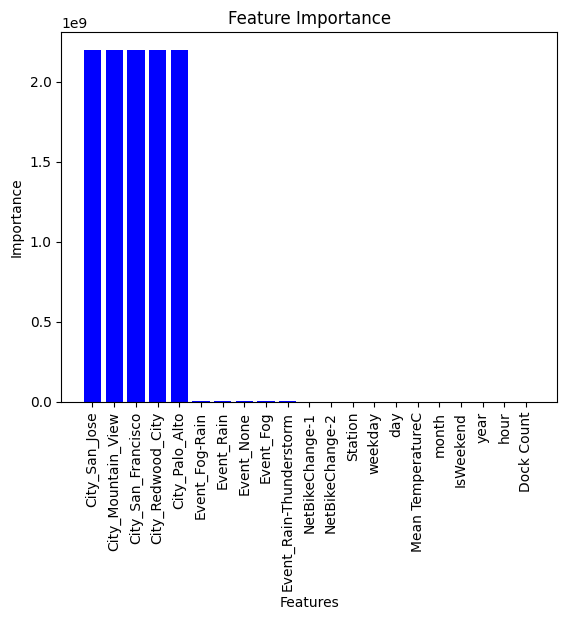

In [193]:
featureImportanceGraph(sorted_features)

Als we de coeficcienten extraheren krijgen we een globaal overzicht op het belang van de verschillende features. Via SHAP kunnen we inzoomen en de contributie van de features binnen één voorbeeld bekijken. 

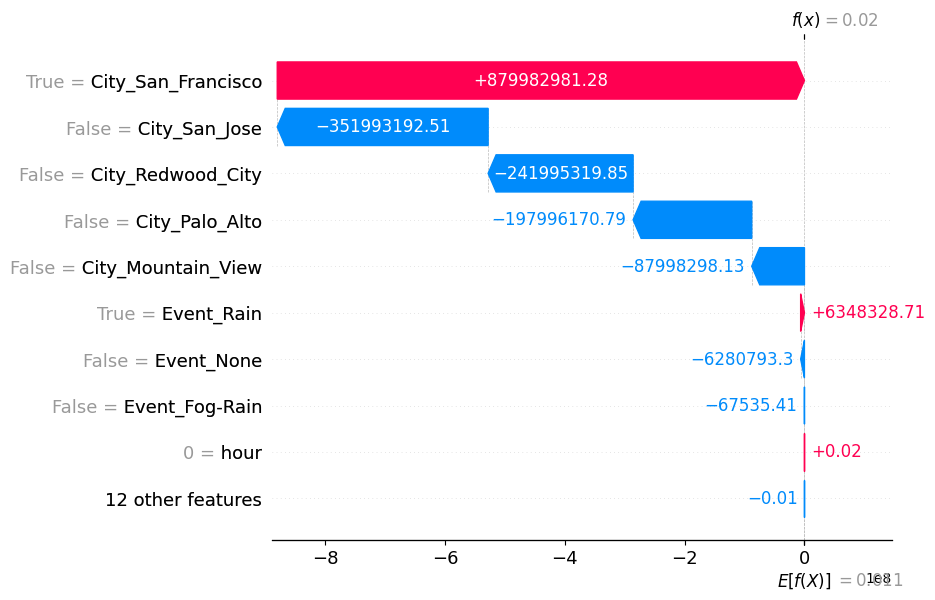

In [194]:
explainer = shap.Explainer(lr, test_df_features)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])


## Laten we nog wat andere modellen proberen

### Ridge regression

Het volgende model dat we proberen is een variatie op lineaire regressie, namelijk Ridge regressie. Ze werken op een gelijkaardige manier, het verschil is dat Ridge regressie een regularisatie term toevoegt. Deze probeert de verschillende gewichten zo klein mogelijk te houden, wat van pas komt gezien de vorige resultaten. Voor deze regularisatie term is een hyperparameter alpha nodig, deze weegt af tussen de gewichten zo klein mogelijk houden en een accuraat model.<br>

De CV (in RidgeCV) staat voor cross-validatie, dit model kiest volgens deze techniek de beste alpha waarde uit een reeks die wij meegeven zonder dat wij een validatie dataset moeten meegeven.


ridge regressor: de MSE error op de test set is: 2.531623802824349
Feature Coefficients:
NetBikeChange-1: 0.34391257589178514
NetBikeChange-2: 0.006277851904580807
City_San_Jose: 0.0027239880653336995
City_Mountain_View: 0.0016937943871690266
Event_Fog-Rain: 0.001013074613533348
Event_Rain: 0.0006026793750590631
Event_None: 0.00044257539085357505
Event_Fog: 0.00031027941612963927
City_San_Francisco: 0.0002977358609418319
Station: 0.00015024525749313377
weekday: 6.6876735509040835e-06
day: -2.3972801083384093e-06
Mean TemperatureC: -3.912383027276516e-06
month: -3.820909157729299e-05
IsWeekend: -0.00015484608348106325
year: -0.00022238655812714306
hour: -0.0014233645276634233
Dock Count: -0.0015706281822850303
City_Redwood_City: -0.0017527532321373004
Event_Rain-Thunderstorm: -0.0023686053035981477
City_Palo_Alto: -0.002962783645460004


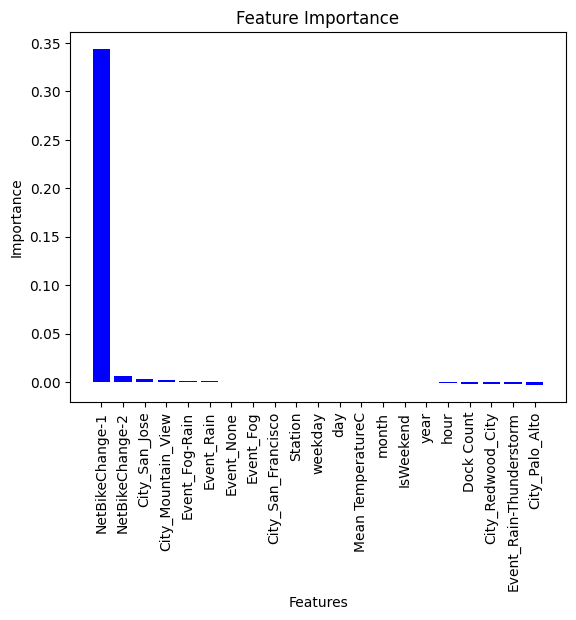

In [195]:
from sklearn.linear_model import Ridge
# Experimenteer met de alpha waarde
ridge = Ridge(alpha=0.1)
ridge.fit(train_df_features, train_target)
predictions= ridge.predict(test_df_features)
ridge_test_MSE = mean_squared_error(test_target,predictions)
print(f"ridge regressor: de MSE error op de test set is: {ridge_test_MSE}")

coefficients = ridge.coef_
ridge_features = sorted(zip(train_df_features.columns, coefficients), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in ridge_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(ridge_features)

ridgeCV regressor: de MSE error op de test set is: 2.531636436021453
Feature Coefficients:
NetBikeChange-1: 0.3429063098629914
NetBikeChange-2: 0.006609043650212865
City_San_Jose: 0.0025906099812453842
City_Mountain_View: 0.0015455502590907139
Event_Fog-Rain: 0.0005622869204058231
City_San_Francisco: 0.00028308454105518965
Event_Rain: 0.0002672162508430831
Station: 0.00014914102616625513
Event_None: 0.00012883291769864164
weekday: 9.059118856041826e-06
Event_Fog: 4.892415563423347e-06
Mean TemperatureC: -2.054813491969565e-06
day: -3.382795230599811e-06
month: -2.6206167841102967e-05
year: -0.0001452325532240728
IsWeekend: -0.0001811495480481401
Event_Rain-Thunderstorm: -0.0009632285045095878
hour: -0.0014246244324844781
Dock Count: -0.0015684431782652108
City_Redwood_City: -0.001687707176831029
City_Palo_Alto: -0.0027315376045628087


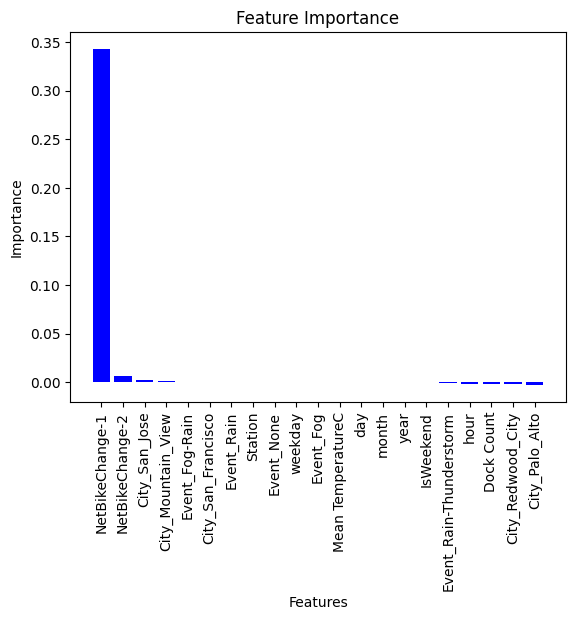

In [196]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-6, 6, 25)
ridgeCV = RidgeCV(alphas=alphas)
ridgeCV.fit(train_df_features, train_target)
predictions= ridgeCV.predict(test_df_features)
ridge_test_MSE = mean_squared_error(test_target,predictions)
print(f"ridgeCV regressor: de MSE error op de test set is: {ridge_test_MSE}")

coefficients = ridgeCV.coef_
ridgeCV_features = sorted(zip(train_df_features.columns, coefficients), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in ridgeCV_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(ridgeCV_features)

Ondanks dat we geen verbetering merken op de test mean squared error in vergelijking met de gewone lineaire regressie, zijn de gewichten van de verschillende features nu overzichtelijker (zonder extreem grote waardes). Hierdoor krijgen we een beter overzicht welke nu van belang zijn.

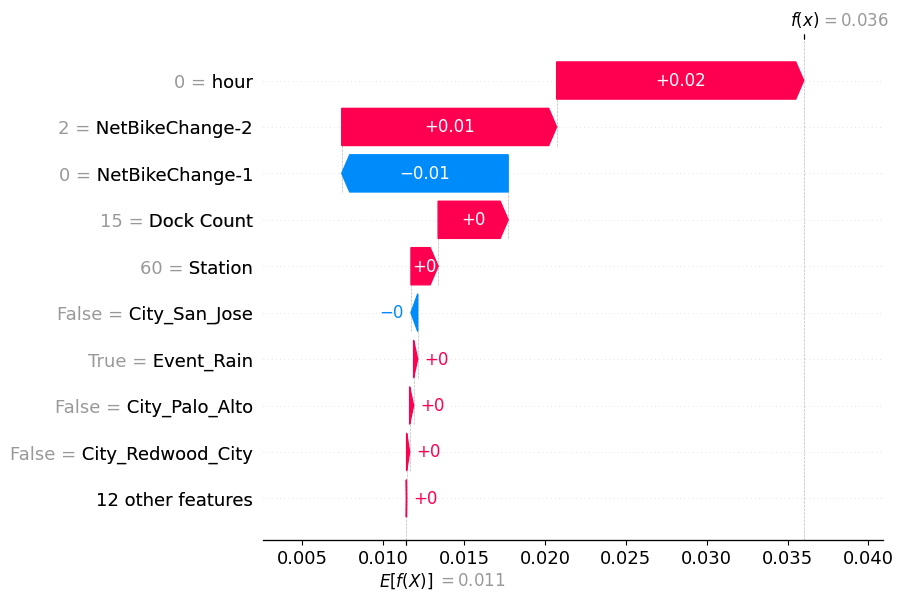

In [197]:
explainer = shap.Explainer(ridgeCV, test_df_features)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[1])


### Decision tree

Vervolgens kunnen we ook even kijken naar beslissingsbomen (decision trees), deze werken aan de hand van slimme vragen over de features die de data telkens opdeelt in 2 delen. De voorspelling is afhankelijk van het eindpunt waar we op belanden na het beantwoorden van alle vragen.<br><br>
Een belangrijke parameter hier is de diepte van de boom, dit vertelt hoeveel vragen we moeten beantwoorden voor we een antwoord krijgen.<br> 
Experimenteer maar even met deze diepte en kijk naar het effect op MSE (normale dieptes zitten tussen de 1 en 10). Het is ook mogelijk om de boom uiteindelijk te plotten via de plot_tree functie

Decision tree: de MSE error op de test set is: 1.9181924535682002
Feature Coefficients:
NetBikeChange-1: 0.3545017529175202
hour: 0.3007867062332586
Station: 0.20548356898854037
Dock Count: 0.06079266758592235
NetBikeChange-2: 0.022165654886334527
weekday: 0.012760991541202527
IsWeekend: 0.010375240761241744
day: 0.010287812348353931
month: 0.008760592409519184
Mean TemperatureC: 0.006975269864192671
City_San_Francisco: 0.0035800048166196425
Event_Fog: 0.0017415928264024687
Event_None: 0.0010646135811772197
Event_Rain: 0.0003084989894673786
City_Mountain_View: 0.0002005482333743547
Event_Fog-Rain: 0.00016389601026207593
City_San_Jose: 2.86537494735802e-05
year: 2.193425713720561e-05
Event_Rain-Thunderstorm: 0.0
City_Palo_Alto: 0.0
City_Redwood_City: 0.0


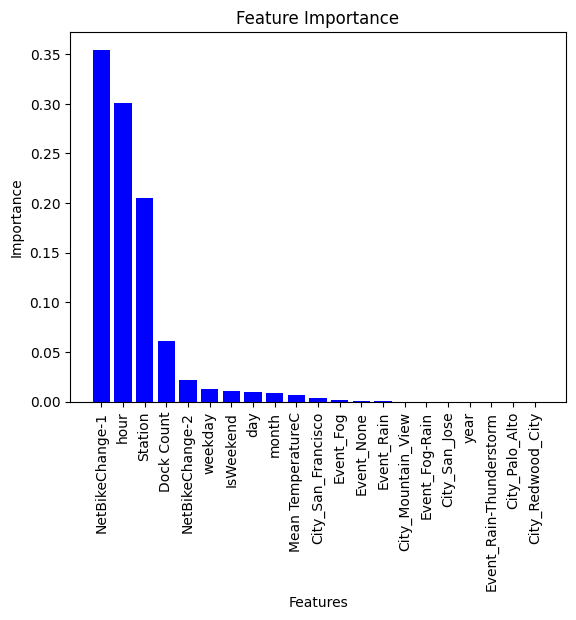

In [198]:
from sklearn import tree
#experimenteer met de diepte
decTree = tree.DecisionTreeRegressor(max_depth=10) 
decTree.fit(train_df_features, train_target)
predictions= decTree.predict(test_df_features)
decTree_test_MSE = mean_squared_error(test_target,predictions)
print(f"Decision tree: de MSE error op de test set is: {decTree_test_MSE}")

feature_importances = decTree.feature_importances_
tree_features = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in tree_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(tree_features)

[Text(0.32580857197161683, 0.9545454545454546, 'x[12] <= -16.5\nsquared_error = 2.442\nsamples = 497952\nvalue = 0.0'),
 Text(0.07678661936137861, 0.8636363636363636, 'x[10] <= 17.5\nsquared_error = 140.0\nsamples = 369\nvalue = -15.103'),
 Text(0.02423340091231627, 0.7727272727272727, 'x[14] <= 67.5\nsquared_error = 79.134\nsamples = 131\nvalue = -26.534'),
 Text(0.015015205271160669, 0.6818181818181818, 'x[9] <= 3.5\nsquared_error = 8.0\nsamples = 3\nvalue = -3.0'),
 Text(0.014001520527116068, 0.5909090909090909, 'squared_error = 0.0\nsamples = 2\nvalue = -1.0'),
 Text(0.01602889001520527, 0.5909090909090909, 'squared_error = 0.0\nsamples = 1\nvalue = -7.0'),
 Text(0.03345159655347187, 0.6818181818181818, 'x[0] <= 16.39\nsquared_error = 67.516\nsamples = 128\nvalue = -27.086'),
 Text(0.018056259503294477, 0.5909090909090909, 'x[13] <= -0.5\nsquared_error = 53.824\nsamples = 91\nvalue = -25.407'),
 Text(0.010770400405473897, 0.5, 'x[9] <= 3.5\nsquared_error = 48.947\nsamples = 84\nval

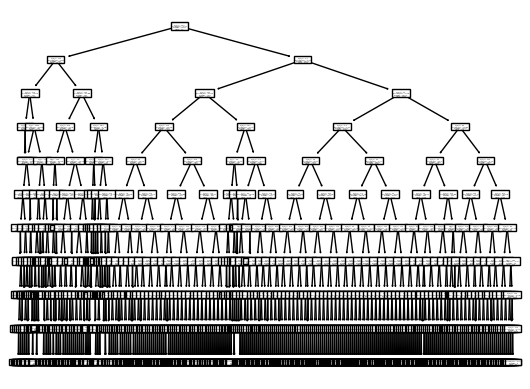

In [199]:
tree.plot_tree(decTree)

Bij een diepte van 10 zien we al een verbetering in de MSE van 2.5 naar minder dan 2 fietsen. We hebben dus een nieuwe beste versie gevonden! Het plotten van de boom is echter wel onoverzichtelijk geworden.<br>
De belangrijkste features waren uiteindelijk:  de 'verandering van fietsen' tijdens het vorige uur, het uur van de dag, het station en het aantal plaatsen voor fietsen.

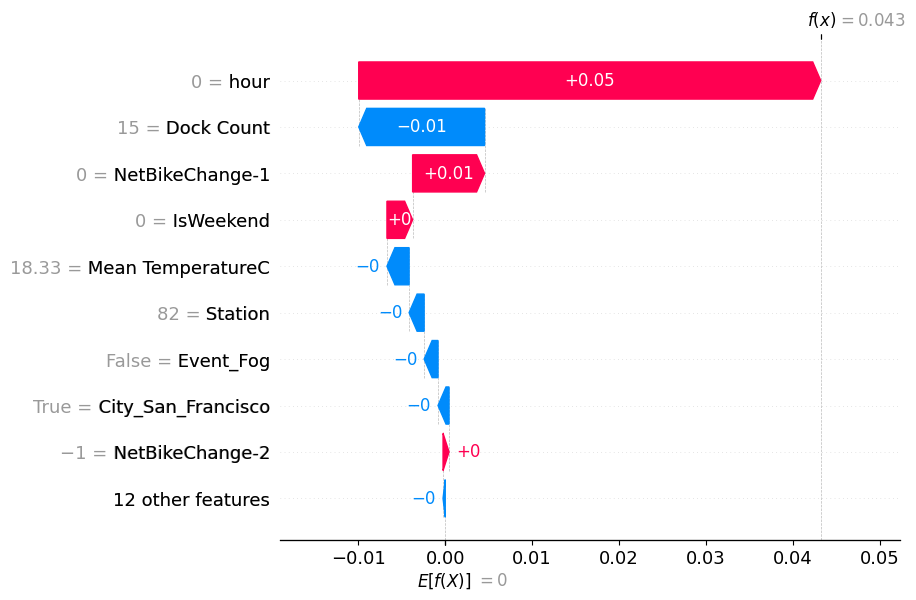

In [200]:
explainer = shap.TreeExplainer(decTree)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])

### Random Forest

Het volgende model dat we gaan uittesten is een random forest regressor. Dit is een ensemble van decision trees (meerdere decision trees), waarbij de resultaten van elke tree samen worden gebracht om het uiteindelijke resultaat te verkrijgen.

Random forest: de MSE error op de test set is: 1.9240091285952803
Feature Coefficients:
NetBikeChange-1: 0.4238709400750037
hour: 0.3104692657796286
Station: 0.17687717026286806
Dock Count: 0.030828004719173213
NetBikeChange-2: 0.02466569459768441
weekday: 0.010173930834046621
Mean TemperatureC: 0.008364970308766897
month: 0.005216110117083757
day: 0.005137812130524262
IsWeekend: 0.0014651449862086911
City_San_Francisco: 0.0007503392959154785
year: 0.0007285990967268878
Event_None: 0.0005145022181453007
Event_Fog: 0.00045432328315940995
Event_Rain: 0.00033853990431118627
Event_Fog-Rain: 0.0001143723385677228
City_San_Jose: 1.1816366357477783e-05
City_Mountain_View: 1.1018612903157812e-05
City_Palo_Alto: 7.4450729250900185e-06
Event_Rain-Thunderstorm: 0.0
City_Redwood_City: 0.0


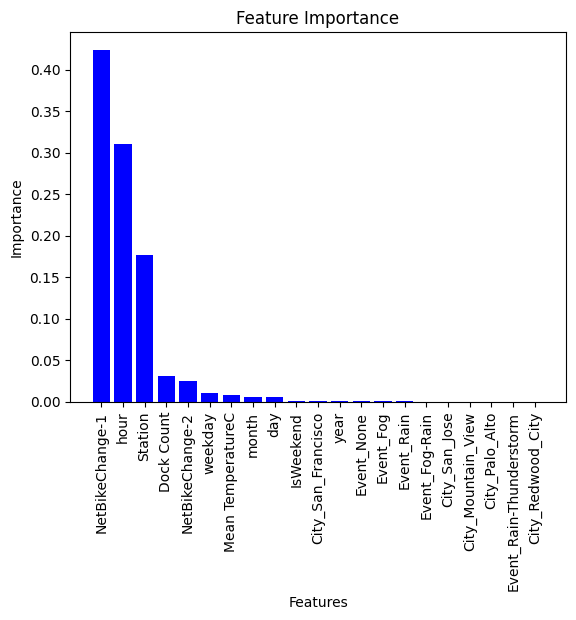

In [201]:
from sklearn.ensemble import RandomForestRegressor

# Experimenteer met de max_depth (diepte) en n_estimators (aantal bomen) parameters
rf = RandomForestRegressor(max_depth=8, n_estimators=25) 
rf.fit(train_df_features, train_target)
predictions= rf.predict(test_df_features)
rf_test_MSE = mean_squared_error(test_target,predictions)
print(f"Random forest: de MSE error op de test set is: {rf_test_MSE}")

feature_importances = rf.feature_importances_
rf_features = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
print('Feature Coefficients:')
for feature, coefficient in rf_features:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(rf_features)

Ondanks dat we werken met 24 extra decision trees blijft de performantie op de testset hetzelfde als die met slechts 1 boom. Dit is dus geen goeie keuze voor ons uiteindelijk model.<br>
We zien ook terug dezelfde meest belangrijke features 

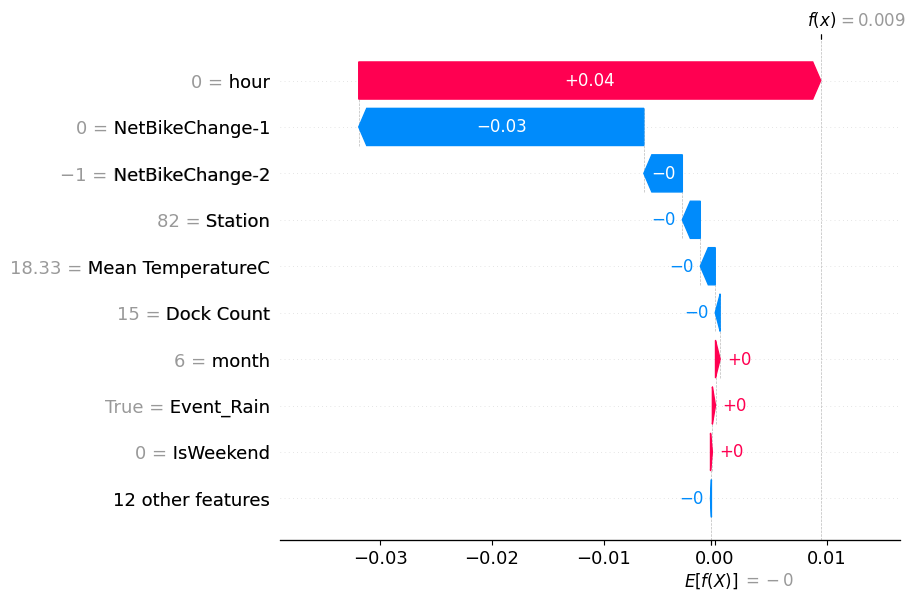

In [202]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])

### Gradient boosting

Vervolgens kunnen we kijken naar een gradient boost variant. Opnieuw een ensemble van beslissingsbomen zoals random forest, maar hier stemmen de verschillende bomen niet op het eindresultaat. Bij gradient boosting probeert elke boom de fouten van de vorige boom te corrigeren. We krijgen dus een serie van beslissingsbomen
Normale gradient boost modellen bevatten ingebouwde functies om het belang van de features te bekijken, maar dit is niet het geval bij de histogram versie. We zullen deze dus opnieuw berekenen aan de hand van permutaties. Een alternatieve manier om de belangen te berekenen. We veranderen telkens de waardes van 1 feature en controleren de invloed op de performantie, hoe groter de invloed hoe belangrijker de feature.<br>


GradientBoosting ensamble: de MSE error op de test set is: 1.611235158169687
hour: 0.4589162116170941
NetBikeChange-1: 0.37035853511241285
Station: 0.22992056509484335
Dock Count: 0.0827193133303326
weekday: 0.04552671946598508
NetBikeChange-2: 0.019510742228849742
City_San_Francisco: 0.009968050274223894
City_San_Jose: 0.00030423510036308165
day: 0.0002556053147803938
Mean TemperatureC: 0.00013451223199107966
City_Palo_Alto: 2.5246232575781847e-05
Event_None: 9.503945768885026e-06
Event_Fog: 0.0
Event_Fog-Rain: 0.0
Event_Rain-Thunderstorm: 0.0
year: 0.0
IsWeekend: 0.0
City_Mountain_View: 0.0
City_Redwood_City: 0.0
Event_Rain: -9.000872936626437e-06
month: -0.00011031277658142269


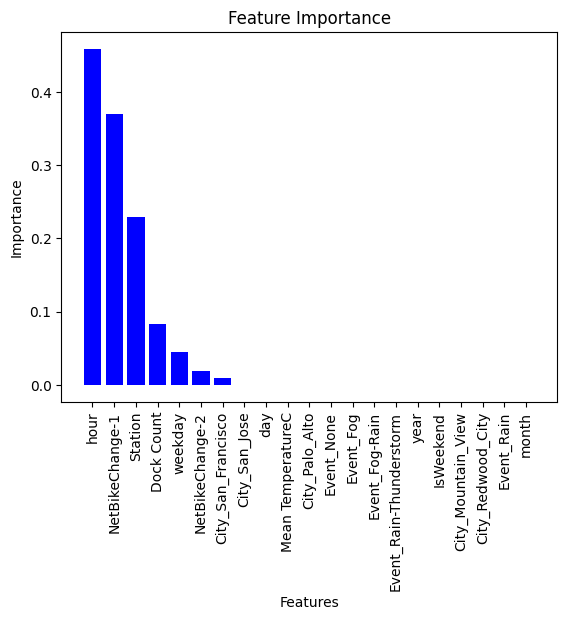

In [203]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

ensambleTree = HistGradientBoostingRegressor()
ensambleTree.fit(train_df_features, train_target)
predictions= ensambleTree.predict(test_df_features)
tree_test_MSE = mean_squared_error(test_target,predictions)
print(f"GradientBoosting ensamble: de MSE error op de test set is: {tree_test_MSE}")

# Een alternatieve manier om het belang van de features te berekenen
result = permutation_importance(ensambleTree, test_df_features, test_target, n_repeats=5, random_state=42)
feature_importances = result.importances_mean
ensambleTreeFeatures = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, coefficient in ensambleTreeFeatures:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(ensambleTreeFeatures)

Dit model is een verbetering ten opzichte van de vorige, we krijgen nu een gemiddelde fout van 1.6 fietsen!<br>
Er wordt hier ook gebruikgemaakt van verschillende features om het eindresultaat te bekomen, de belangrijkste zijn het uur van de dag, de verandering van fietsen vorig uur en het station zelf.

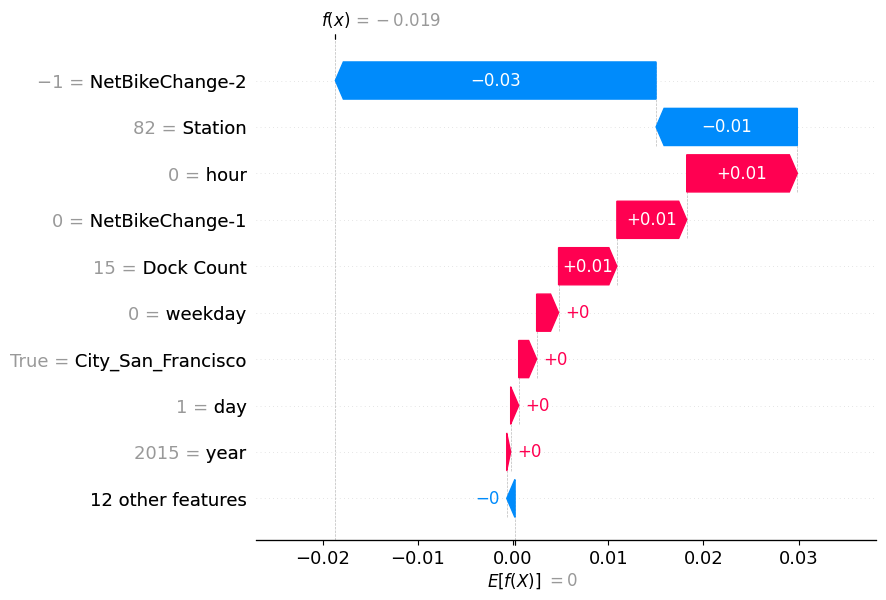

In [204]:
explainer = shap.TreeExplainer(ensambleTree)
shap_values = explainer(test_df_features)
shap.plots.waterfall(shap_values[0])


### Multilayer perceptron

We hebben nu al 2 lineaire modellen en 3 beslissingsbomen getraind. Laten we dan eens kijken naar wat complexere modellen, zoals een neuraal netwerk.Meer specifiek een multilayer perceptron (MLP), MLP betekent gewoon verschillende lagen aan neuronen (of perceptrons) en is de simpelste variant van een neuraal netwerk.<br>
De output van iedere neuron is de lineaire combinatie van de outputs van de vorige laag, we voegen non-lineariteit toe door middel van een activatiefunctie toe te passen op de neuron outputs.<br><br>
Dit complexere model geeft meer flexibiliteit maar maakt het ook moeilijker om het belang van de verschillende features te vinden (black box). 

Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.


Multilayer perceptron: de MSE error op de test set is: 2.649836410990456
NetBikeChange-1: 0.2131696709616711
City_San_Francisco: 0.00022050602921017682
City_San_Jose: 0.00017744033833340113
City_Redwood_City: 0.0001269026697101383
City_Palo_Alto: 0.00012013967701371975
City_Mountain_View: 0.00011901700952410277
hour: 9.223705177163755e-05
Dock Count: 8.629767585208726e-05
month: 2.1144699978847827e-05
Station: 2.0194676123908017e-05
Mean TemperatureC: 1.7638278932019524e-05
IsWeekend: 1.4065693304687876e-05
Event_None: 1.9186452461461557e-06
Event_Rain: 1.8619053113289042e-06
Event_Rain-Thunderstorm: 1.790815384228317e-06
Event_Fog: 0.0
year: 0.0
Event_Fog-Rain: -4.843664255460567e-07
day: -1.1346422129188127e-05
weekday: -5.9466604722802076e-05
NetBikeChange-2: -9.694320944710899e-05


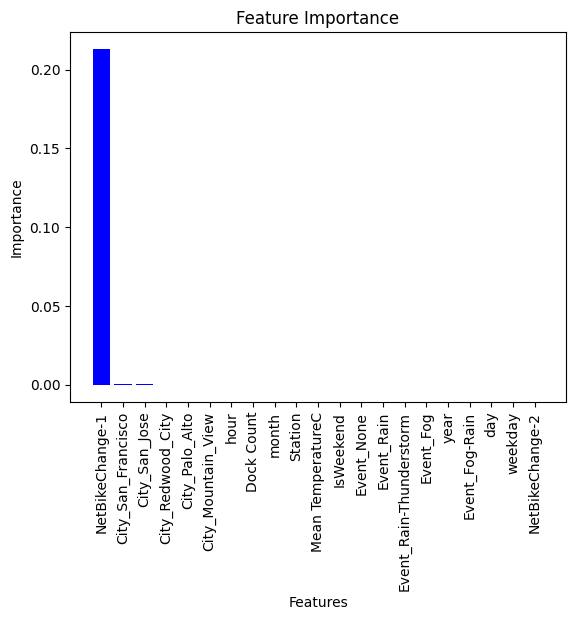

In [205]:
from sklearn.neural_network import MLPRegressor
# Test verschillende netwerk groottes en dieptes (Gelieve deze wel redelijk te houden zodat de cluster dit aankan)
mlp = MLPRegressor(hidden_layer_sizes=(32, 16,8),random_state=1, max_iter=5)
mlp.fit(train_df_features, train_target)
predictions= mlp.predict(test_df_features)
mlp_test_MSE = mean_squared_error(test_target,predictions)
print(f"Multilayer perceptron: de MSE error op de test set is: {mlp_test_MSE}")

# Een alternatieve manier om het belang van de features te berekenen
result = permutation_importance(mlp, test_df_features, test_target, n_repeats=5, random_state=42)
feature_importances = result.importances_mean
MlpFeatures = sorted(zip(train_df_features.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, coefficient in MlpFeatures:
    print(f'{feature}: {coefficient}')
featureImportanceGraph(MlpFeatures)

Ondanks dat we een complexer, non-lineair model gebruiken zien we geen verbetering in performance, integendeel zelfs. Een zo complex mogelijk model op een probleem gooien is dus niet altijd de oplossing.<br>
De verandering van fietsen tijdens het vorige uur is hier veruit het belangrijkste feature.

# Visualiseer de resultaten

Nu hebben we enkele modellen getraind en klaar voor gebruik binnen het beachboys bikesharing bedrijf. Alhoewel sommige van deze modellen al een redelijke prestatie halen, is er altijd ruimte voor verbetering. Net zoals bij de start van de workshop, beginnen we hier aan door inzichten te krijgen in de data. Hier zijn nu de voorspellingen gemaakt door de verschillende modellen bij gekomen. We kunnen eens kijken hoe deze afwegen tegen de realiteit, en zo leren waar ze in de mist gaan.

Eerst kiezen we een bepaalde dag en station uit de test set om te plotten (tussen 1 juni en 14 augustus):

In [206]:
# Experimenteer maar met deze waardes
station = 70 #dit is een vrij druk station
maand = 8
dag= 11

viz_data = test_df[(test_df['Station']== station)&(test_df['day']== dag)&(test_df['month']== maand)]
viz_data_target = viz_data['netBikeChange']
viz_data_features = viz_data.drop('netBikeChange',axis=1)



De volgende code genereert een plot voor ons, we kiezen zelf gewooon het te gebruiken model.

**Model type: variabele met getraind model**<br>
Lineaire regressie: lr <br>
Ridge regression: ridgeCV <br>
Decision tree: decTree<br>
Random forest: rf <br>
Gradient Boosting: ensambleTree <br>
multilayer perceptron: mlp <br>

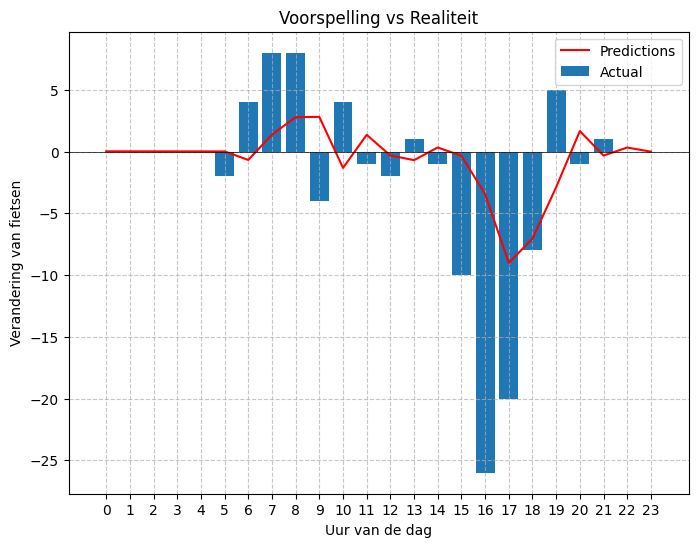

In [207]:
# test verschillende modellen uit
model = lr

predictions = model.predict(viz_data_features)
plt.figure(figsize=(8, 6))
plt.plot(viz_data_features['hour'],predictions, label ='Predictions',color='r')
plt.bar(viz_data_features['hour'], viz_data_target, label='Actual')
plt.xlabel('Uur van de dag')
plt.xticks(viz_data_features['hour'])
plt.ylabel('Verandering van fietsen')
plt.title(f'Voorspelling vs Realiteit')
plt.grid(True, linestyle='--', alpha=0.7)

# Adding origin lines (axes lines)
plt.axhline(0, color='black',linewidth=0.5)
plt.legend()
plt.show()
